## Today I'll be working on the cabin column.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = "../../../Data/titanic/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [4]:
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [5]:
train["Deck"] = train["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else "M")
train.drop("Cabin", axis=1, inplace=True)

### Visualization of Deck in Train.

Let's start by viewing passenger class distribution in each deck.

In [8]:
decks_ = ["A", "B", "C", "D", "E", "F", "G", "T", "M"]
deck_dist = np.zeros((9, 3))

# We fill the matrix with the passenger distributions.
for i in range(len(decks_)):
    pclass_dist = train[train["Deck"]==decks_[i]].groupby("Pclass")["Pclass"].count()
    for pclass, pclass_count in pclass_dist.items():
        deck_dist[i, pclass-1] = pclass_count

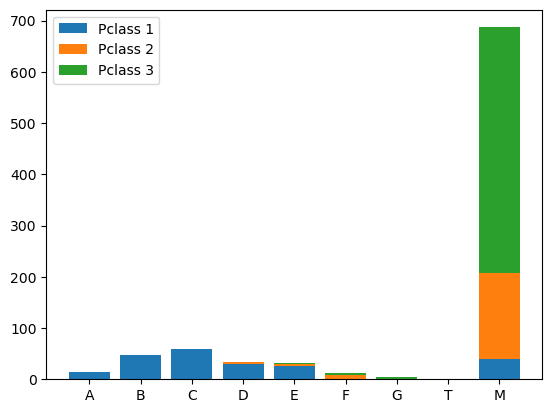

In [21]:
fig, ax = plt.subplots()
ax.bar(decks_, deck_dist[:, 0], label="Pclass 1")
ax.bar(decks_, deck_dist[:, 1], bottom=deck_dist[:, 0], label="Pclass 2")
ax.bar(decks_, deck_dist[:, 2], bottom=deck_dist[:, 0] + deck_dist[:, 1], label="Pclass 3")
plt.legend()
plt.show()